# User Engagement analysis

In [20]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
sys.path.append(os.path.abspath('../scripts'))
sys.path.append(os.path.abspath('../src'))

In [2]:
from load_data import load_data_from_postgres, check_duplicates, check_numeric_anomalies, get_numeric_columns
from utils import bytes_to_gigabytes, kilobytes_per_second_to_megabytes_per_second, milliseconds_to_hours, milliseconds_to_minutes, bytes_to_megabytes, milliseconds_to_seconds

In [3]:
query = "select * from cleaned_xdr_data;"

df = load_data_from_postgres(query)
df.tail(5)

c:\Users\Hp\Desktop\Kifiya\Week 2\TellCo’s Growth Analysis\scripts\load_data.py:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
149996,7.277826e+18,2019-04-29 07:28:00,451.0,2019-04-30 06:02:00,214.0,81230.0,2.082022e+14,3.365069e+10,3.548311e+13,D20434A,...,1.619167e+07,1.176343e+07,1.788370e+07,1.967816e+07,5.266097e+08,9.197207e+06,3.264510e+06,1.348742e+07,57628851.0,574175259.0
149997,7.349883e+18,2019-04-29 07:28:00,483.0,2019-04-30 10:41:00,187.0,97970.0,2.082019e+14,3.366345e+10,3.566051e+13,D10223C,...,1.387723e+07,8.288284e+06,1.935015e+07,2.129315e+07,6.268931e+08,4.735033e+06,7.121804e+08,2.457758e+06,39135081.0,666648844.0
149998,1.311448e+19,2019-04-29 07:28:00,283.0,2019-04-30 10:46:00,810.0,98249.0,2.082017e+14,3.362189e+10,3.572121e+13,T51102A,...,2.266051e+07,1.855903e+06,9.963942e+06,5.065760e+06,5.535395e+08,1.339432e+07,1.211009e+08,1.131473e+07,34912224.0,592786405.0
149999,1.311448e+19,2019-04-29 07:28:00,696.0,2019-04-30 10:40:00,327.0,97910.0,2.082021e+14,3.361962e+10,8.618620e+13,L88342B,...,8.817106e+06,8.305402e+06,3.322253e+06,1.317259e+07,3.525370e+08,2.529475e+06,8.147131e+08,1.406930e+06,29626096.0,371895920.0
150000,-1.000000e+00,1900-01-01 00:00:00,-1.0,1900-01-01 00:00:00,-1.0,-1.0,-1.000000e+00,-1.000000e+00,-1.000000e+00,Unknown,...,1.163407e+07,1.100941e+07,1.162685e+07,1.100175e+07,4.220447e+08,8.288398e+06,4.211005e+08,8.264799e+06,-1.0,-1.0


In [4]:
# checking for duplicated rows in the datasets
duplicate_rows = check_duplicates(df)
print(duplicate_rows)

Success: No duplicated values.


In [5]:
# list all numberical columns 
numeric_columns = get_numeric_columns(df)
print(numeric_columns)

['Bearer Id', 'Start ms', 'End ms', 'Dur. (ms)', 'IMSI', 'MSISDN/Number', 'IMEI', 'Avg RTT DL (ms)', 'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)', 'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)', 'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)', '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)', 'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)', '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)', 'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)', 'Activity Duration UL (ms)', 'Dur. (ms).1', 'Nb of sec with 125000B < Vol DL', 'Nb of sec with 1250B < Vol UL < 6250B', 'Nb of sec with 31250B < Vol DL < 125000B', 'Nb of sec with 37500B < Vol UL', 'Nb of sec with 6250B < Vol DL < 31250B', 'Nb of sec with 6250B < Vol UL < 37500B', 'Nb of sec with Vol DL < 6250B', 'Nb of sec with Vol UL < 1250B', 'Social Media DL (Bytes)', 'Social Media UL (Bytes)', 'Google DL (Bytes)', 'Google UL (Bytes)', 'Email DL (Bytes)', 'Email 

In [6]:
# checking for anomalies in all numeric columns
for numeric_column in numeric_columns:
    numeric_anomalies = check_numeric_anomalies(df, numeric_column, lower_bound=0, upper_bound=None)
    print(numeric_anomalies)

Success: No anomalies detected.
Success: No anomalies detected.
Success: No anomalies detected.
Success: No anomalies detected.
Success: No anomalies detected.
Success: No anomalies detected.
Success: No anomalies detected.
Success: No anomalies detected.
Success: No anomalies detected.
Success: No anomalies detected.
Success: No anomalies detected.
Success: No anomalies detected.
Success: No anomalies detected.
Success: No anomalies detected.
Success: No anomalies detected.
Success: No anomalies detected.
Success: No anomalies detected.
Success: No anomalies detected.
Success: No anomalies detected.
Success: No anomalies detected.
Success: No anomalies detected.
Success: No anomalies detected.
Success: No anomalies detected.
Success: No anomalies detected.
Success: No anomalies detected.
Success: No anomalies detected.
Success: No anomalies detected.
Success: No anomalies detected.
Success: No anomalies detected.
Success: No anomalies detected.
Success: No anomalies detected.
Success:

In [7]:
# Customizing some columns and do some unit conversions 
df['Social Media (GB)'] = df['Social Media DL (Bytes)'].apply(bytes_to_megabytes) + df['Social Media UL (Bytes)'].apply(bytes_to_megabytes)
df['Youtube (GB)'] = df['Youtube DL (Bytes)'].apply(bytes_to_megabytes) + df['Youtube UL (Bytes)'].apply(bytes_to_megabytes)
df['Google (GB)'] = (df['Google DL (Bytes)'] + df['Google UL (Bytes)']).apply(bytes_to_megabytes)
df['Email (GB)'] = (df['Email DL (Bytes)'] + df['Email UL (Bytes)']).apply(bytes_to_megabytes)
df['Netflix (GB)'] = (df['Netflix DL (Bytes)'] + df['Netflix UL (Bytes)']).apply(bytes_to_megabytes)
df['Gaming (GB)'] = (df['Gaming DL (Bytes)'] + df['Gaming UL (Bytes)']).apply(bytes_to_megabytes)
df['Other (GB)'] = (df['Other DL (Bytes)'] + df['Other UL (Bytes)']).apply(bytes_to_megabytes)
df['Total Data (GB)'] = df['Total DL (Bytes)'].apply(bytes_to_megabytes) + df['Total UL (Bytes)'].apply(bytes_to_megabytes)
df['Dur. (hr)'] = df['Dur. (ms).1'].apply(milliseconds_to_hours)
df['Avg RTT DL (sec)'] = df['Avg RTT DL (ms)'].apply(milliseconds_to_seconds)
df['Avg RTT UL (sec)'] = df['Avg RTT UL (ms)'].apply(milliseconds_to_seconds)
df['Avg Bearer TP DL (Mbps)'] = df['Avg Bearer TP DL (kbps)'].apply(kilobytes_per_second_to_megabytes_per_second)
df['Avg Bearer TP UL (Mbps)'] = df['Avg Bearer TP UL (kbps)'].apply(kilobytes_per_second_to_megabytes_per_second)

# Apply conversion functions to columns and store results in new columns
df['Total DL (Mb)'] = df['Total DL (Bytes)'].apply(bytes_to_megabytes)
df['Total UL (Mb)'] = df['Total UL (Bytes)'].apply(bytes_to_megabytes)
df['Social Media DL (Mb)'] = df['Social Media DL (Bytes)'].apply(bytes_to_megabytes)
df['Social Media UL (Mb)'] = df['Social Media UL (Bytes)'].apply(bytes_to_megabytes)
df['Google DL (Mb)'] = df['Google DL (Bytes)'].apply(bytes_to_megabytes)
df['Google UL (Mb)'] = df['Google UL (Bytes)'].apply(bytes_to_megabytes)
df['Email DL (Mb)'] = df['Email DL (Bytes)'].apply(bytes_to_megabytes)
df['Email UL (Mb)'] = df['Email UL (Bytes)'].apply(bytes_to_megabytes)
df['Youtube DL (Mb)'] = df['Youtube DL (Bytes)'].apply(bytes_to_megabytes)
df['Youtube UL (Mb)'] = df['Youtube UL (Bytes)'].apply(bytes_to_megabytes)
df['Netflix DL (Mb)'] = df['Netflix DL (Bytes)'].apply(bytes_to_megabytes)
df['Netflix UL (Mb)'] = df['Netflix UL (Bytes)'].apply(bytes_to_megabytes)
df['Gaming DL (Mb)'] = df['Gaming DL (Bytes)'].apply(bytes_to_megabytes)
df['Gaming UL (Mb)'] = df['Gaming UL (Bytes)'].apply(bytes_to_megabytes)
df['Other DL (Mb)'] = df['Other DL (Bytes)'].apply(bytes_to_megabytes)
df['Other UL (Mb)'] = df['Other UL (Bytes)'].apply(bytes_to_megabytes)
df['Dur. (hr)'] = df['Dur. (ms).1'].apply(milliseconds_to_hours)
df['Dur. (sec)'] = df['Dur. (ms).1'].apply(milliseconds_to_seconds)

# Calculate total data volume (DL+UL) for each application
df['Social Media Data (Mb)'] = df['Social Media DL (Mb)'] + df['Social Media UL (Mb)']
df['Youtube Data (Mb)'] = df['Youtube DL (Mb)'] + df['Youtube UL (Mb)']
df['Email Data (Mb)'] = df['Email DL (Mb)'] + df['Email UL (Mb)']
df['Gaming Data (Mb)'] = df['Gaming DL (Mb)'] + df['Gaming UL (Mb)']
df['Netflix Data (Mb)'] = df['Netflix DL (Mb)'] + df['Netflix UL (Mb)']
df['Google Data (Mb)'] = df['Google DL (Mb)'] + df['Google UL (Mb)']
df['Other Data (Mb)'] = df['Other DL (Mb)'] + df['Other UL (Mb)']
df['Total Data (Mb)'] = df['Total DL (Mb)'] + df['Total UL (Mb)']
df['Avg Bearer TP (Mbps)'] = df['Avg Bearer TP DL (Mbps)'] + df['Avg Bearer TP UL (Mbps)']
df['Avg RTT (sec)'] = df['Avg RTT DL (sec)'] + df['Avg RTT UL (sec)']
df['TCP Retrans. Vol (Bytes)'] = df['TCP DL Retrans. Vol (Bytes)'] + df['TCP UL Retrans. Vol (Bytes)']
df['TCP Retrans. Vol (Mb)'] = df['TCP Retrans. Vol (Bytes)'].apply(bytes_to_megabytes)

# Convert 'Start' to datetime format
df['Start'] = pd.to_datetime(df['Start'])

# Extract date part only and save it to a new column 'Date'
df['Date'] = df['Start'].dt.date

In [8]:
# Create a new DataFrame with selected columns
selected_columns = ['Total Data (Mb)', 'MSISDN/Number', 'Date',
                    'Handset Manufacturer', 'Handset Type', 'Bearer Id',
                    'Avg Bearer TP (Mbps)', 'TCP Retrans. Vol (Mb)', 'Avg RTT (sec)',
                    'Dur. (hr)',
                    'Last Location Name',
                    'Gaming Data (Mb)', 'Netflix Data (Mb)', 'Email Data (Mb)', 'Google Data (Mb)', 'Youtube Data (Mb)', 'Social Media Data (Mb)', 'Other Data (Mb)']

df_relevant = df[selected_columns]
print(df_relevant.columns)

Index(['Total Data (Mb)', 'MSISDN/Number', 'Date', 'Handset Manufacturer',
       'Handset Type', 'Bearer Id', 'Avg Bearer TP (Mbps)',
       'TCP Retrans. Vol (Mb)', 'Avg RTT (sec)', 'Dur. (hr)',
       'Last Location Name', 'Gaming Data (Mb)', 'Netflix Data (Mb)',
       'Email Data (Mb)', 'Google Data (Mb)', 'Youtube Data (Mb)',
       'Social Media Data (Mb)', 'Other Data (Mb)'],
      dtype='object')


## Step 1: Aggregate Metrics per Customer ID (MSISDN)

In [9]:
df_filtered = df[df['MSISDN/Number'] != -1]
agg_metrics = df_filtered.groupby('MSISDN/Number').agg({
    'Bearer Id': 'nunique',
    'Dur. (hr)': 'sum',
    'Total Data (Mb)': 'sum'
}).reset_index()

agg_metrics.rename(columns={
    'Bearer Id': 'session_frequency',
    'Dur. (hr)': 'total_duration',
    'Total Data (Mb)': 'total_traffic'
}, inplace=True)

## Step 2: Report the Top 10 Customers per Engagement Metric

In [10]:
top_10_frequency = agg_metrics.nlargest(10, 'session_frequency')
top_10_duration = agg_metrics.nlargest(10, 'total_duration')
top_10_traffic = agg_metrics.nlargest(10, 'total_traffic')
top_10_frequency 


,MSISDN/Number,session_frequency,total_duration,total_traffic
13526,3.362632e+10,18,2442.204633,7601.897489
6437,3.361489e+10,17,2768.584933,8436.419004
13180,3.362578e+10,17,5153.823191,8105.869982
37052,3.365973e+10,16,1120.954514,7348.883422
76363,3.367588e+10,15,1351.653841,7525.549515
92923,3.376054e+10,15,2577.622778,8120.321239
65118,3.366716e+10,13,2429.145006,5358.118109
666,3.360313e+10,12,1746.602079,4745.669406
1279,3.360452e+10,12,1446.665392,5233.626645
13994,3.362708e+10,12,1306.533131,5488.139018


## Step 3: Normalize Each Engagement Metric

In [11]:
scaler = MinMaxScaler()
normalized_metrics = scaler.fit_transform(agg_metrics[['session_frequency', 'total_duration', 'total_traffic']])

# Step 4: Run K-Means Clustering (k=3)

In [12]:
Kmeans = KMeans(n_clusters=3, random_state=42)
agg_metrics['cluster'] = Kmeans.fit_predict(normalized_metrics)

## Step 5: Compute Metrics for Each Cluster

In [13]:
# compute metrics for each cluster 
cluster_metrics = agg_metrics.groupby('cluster').agg({
    'session_frequency': ['min', 'max', 'mean', 'sum'],
    'total_duration': ['min', 'max', 'mean', 'sum'],
    'total_traffic': ['min', 'max', 'mean', 'sum']
}).reset_index()

# Step 6: Visualize and Interpret Results

<function matplotlib.pyplot.show(close=None, block=None)>

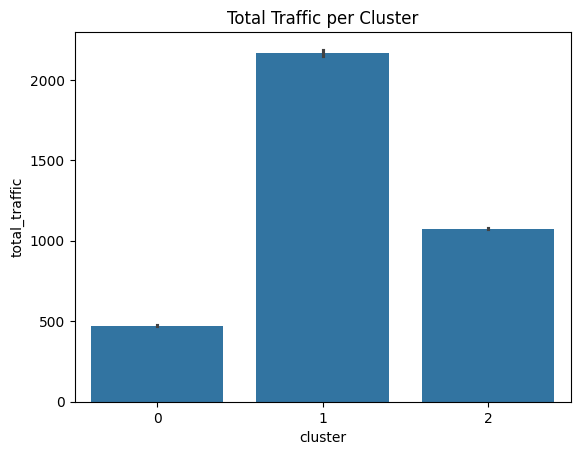

In [14]:
# visualize total traffic per cluster 
sns.barplot(x='cluster', y='total_traffic', data=agg_metrics)
plt.title('Total Traffic per Cluster')
plt.show

## Step 7: Aggregate User Total Traffic per Application

In [17]:
app_traffic = df_filtered.groupby(['MSISDN/Number']).agg({
     'Gaming Data (Mb)': 'sum',
    'Netflix Data (Mb)': 'sum',
    'Email Data (Mb)': 'sum',
    'Google Data (Mb)': 'sum',
    'Youtube Data (Mb)': 'sum',
    'Social Media Data (Mb)': 'sum',
    'Other Data (Mb)': 'sum'
}).reset_index()

## Step 8: Derive Top 10 Most Engaged Users per Application

In [21]:
# Top 10 users per application
top_10_gaming = app_traffic.nlargest(10, 'Gaming Data (Mb)')
top_10_netflix = app_traffic.nlargest(10, 'Netflix Data (Mb)')
top_10_email = app_traffic.nlargest(10, 'Email Data (Mb)')
top_10_google = app_traffic.nlargest(10, 'Google Data (Mb)')
top_10_youtube = app_traffic.nlargest(10, 'Youtube Data (Mb)')
top_10_social_media = app_traffic.nlargest(10, 'Social Media Data (Mb)')
top_10_other = app_traffic.nlargest(10, 'Other Data (Mb)')

# Function to create interactive bar chart
def create_bar_chart(data, x_col, y_col, title):
    fig = px.bar(data, x=x_col, y=y_col, 
                 labels={x_col: 'MSISDN/Number', y_col: 'Total Data Usage (Mb)'},
                 title=title)
    fig.show()

# Plotting the top 10 users per application
create_bar_chart(top_10_gaming, 'MSISDN/Number', 'Gaming Data (Mb)', 'Top 10 Users by Gaming Data Usage')
create_bar_chart(top_10_netflix, 'MSISDN/Number', 'Netflix Data (Mb)', 'Top 10 Users by Netflix Data Usage')
create_bar_chart(top_10_email, 'MSISDN/Number', 'Email Data (Mb)', 'Top 10 Users by Email Data Usage')
create_bar_chart(top_10_google, 'MSISDN/Number', 'Google Data (Mb)', 'Top 10 Users by Google Data Usage')
create_bar_chart(top_10_youtube, 'MSISDN/Number', 'Youtube Data (Mb)', 'Top 10 Users by YouTube Data Usage')
create_bar_chart(top_10_social_media, 'MSISDN/Number', 'Social Media Data (Mb)', 'Top 10 Users by Social Media Data Usage')
create_bar_chart(top_10_other, 'MSISDN/Number', 'Other Data (Mb)', 'Top 10 Users by Other Data Usage')

## Step 9: Plot the Top 3 Most Used Applications Using Plotly

In [23]:
# Calculate total usage for each application
app_usage = app_traffic.drop(columns=['MSISDN/Number']).sum()

# Sort application by usage and select the top 3
top_3_apps = app_usage.sort_values(ascending=False).iloc[:3]

# Create a bar plot for the top 3 most used applications
fig = px.bar(top_3_apps, x=top_3_apps.index, y=top_3_apps.values,
             labels={'x': 'Application', 'y': 'Total usage (mb)'},
             title = 'Top 3 Most Used Applications')

#show plot 
fig.show()


## Step 10: Optimize K for K-Means Clustering Using Elbow Method

In [24]:
# Elbow method to detrmine optimal k 
sse = []
for k in range(1, 11):
    Kmeans = KMeans(n_clusters=k, random_state=42)
    Kmeans.fit(normalized_metrics)
    sse.append(Kmeans.inertia_)

# Create an interactive plot for the elbow method 
fig = px.line(x=range(1, 11), y=sse, labels={'x': 'Number of Clusters', 'y': 'SSE'},
              title='Elbow Method for Optimal k')

# show the plot 
fig.show()